In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from sklearn.decomposition import PCA

In [2]:
torch.manual_seed(1)
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [3]:
def load_data(train_batch_size, test_batch_size):
    
    training_dataset = datasets.MNIST('data', train=True, download=True, 
                transform=transforms.Compose([transforms.ToTensor()]))
    training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=train_batch_size, shuffle=True)

    testing_dataset = datasets.MNIST('data', train=False, download=True, 
                transform=transforms.Compose([transforms.ToTensor()]))
    testing_loader = torch.utils.data.DataLoader(testing_dataset, batch_size=test_batch_size, shuffle=True)

    return training_loader, testing_loader

In [4]:
class CustomModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.input_layer = nn.Linear(784, 10)
        self.hidden_layer = nn.Linear(10, 20)
        self.output_layer = nn.Linear(20, 10)

    def forward(self, inputs):
        inputs = F.relu(self.input_layer(inputs))
        inputs = F.relu(self.hidden_layer(inputs))
        inputs = self.output_layer(inputs)
        return inputs

In [5]:
def calculate_loss_accuracy(model, data_loader, loss_function):
    total_correct = 0
    total_samples = 0
    total_loss = 0
    num_batches = 0
    with torch.no_grad():
        for batch in data_loader:
            images, labels = batch
            predictions = model(images.view(-1, 784))
            loss = loss_function(predictions, labels)
            total_loss += loss
            num_batches += 1
            for idx, predicted_tensor in enumerate(predictions):
                if torch.argmax(predicted_tensor) == labels[idx]:
                    total_correct += 1
                total_samples += 1
    return total_loss / num_batches, round(total_correct / total_samples, 3)

In [6]:
def train_model(model, epochs):
    model.train()
    epoch_counter = 0
    weight_history = pd.DataFrame()
    
    for epoch_counter in range(epochs):
        for _, (image_batch, label_batch) in enumerate(train_loader):  
            image_batch, label_batch = Variable(image_batch), Variable(label_batch)     
            optimizer.zero_grad()
            predictions = model(image_batch.view(-1, 784))
            loss = loss_fn(predictions, label_batch)
            loss.backward()
            optimizer.step()

        temp_weights = pd.DataFrame()
        for name, parameter in model.named_parameters():
            if 'weight' in name:
                weight_vector = torch.nn.utils.parameters_to_vector(parameter).detach().numpy() 
                temp_weights = pd.concat([temp_weights, pd.DataFrame(weight_vector).T], axis=1)
        weight_history = pd.concat([weight_history, temp_weights], axis=0)
        
        train_loss, train_accuracy = calculate_loss_accuracy(current_model, train_loader, loss_fn)
        test_loss, test_accuracy = calculate_loss_accuracy(current_model, test_loader, loss_fn)

        training_loss.append(train_loss)
        testing_loss.append(test_loss)
        training_accuracy.append(train_accuracy)
        testing_accuracy.append(test_accuracy)

    return weight_history


In [7]:
train_batch_size = 1000
test_batch_size = 1000
train_loader, test_loader = load_data(train_batch_size, test_batch_size)
training_loss = []
testing_loss = []
training_accuracy = []
testing_accuracy = []

In [9]:
max_epochs = 29
complete_weights = pd.DataFrame()
plot_columns = ["x", "y", "Iterations"]

loss_fn = nn.CrossEntropyLoss()

for iteration in range(7):
    print(f"Iteration: {iteration}")
    current_model = CustomModel()
    optimizer = torch.optim.Adam(current_model.parameters(), lr=0.0004, weight_decay=1e-4)
    temp_weights = train_model(current_model, max_epochs)
    complete_weights = pd.concat([complete_weights, temp_weights])

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6


In [12]:
weights_data = complete_weights
weights_data = np.array(weights_data)
pca = PCA(n_components=2)
pca_transformed = pca.fit_transform(weights_data)

In [13]:
weights_df = pd.DataFrame(pca_transformed, columns=['x', 'y'])

# Ensure we take the correct slice of training accuracy and loss
num_entries = len(weights_df)
weights_df['Accuracy'] = training_accuracy[:num_entries]
weights_df['Loss'] = training_loss[:num_entries]
final_data = weights_df.iloc[::3, :]

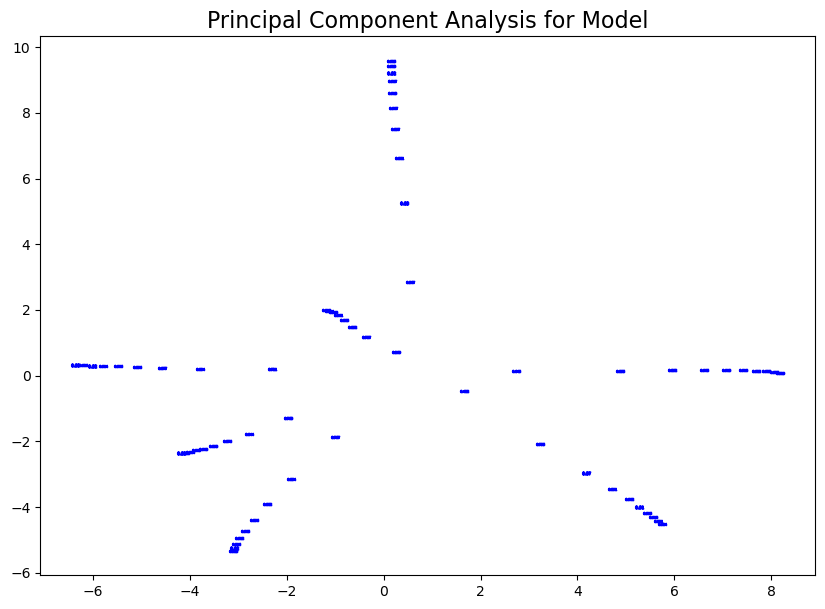

In [14]:
plt.figure(figsize=(10, 7))
for idx in range(1, 66):
    accuracy_value = list(final_data['Accuracy'])[idx]
    plt.scatter(final_data['x'][idx*3], final_data['y'][idx*3], marker=f'${accuracy_value}$', color='blue')
    plt.title("Principal Component Analysis for Model", fontsize=16)
plt.show()


In [15]:
first_layer_weights = complete_weights.iloc[:, :7840]

In [16]:

weights_data = first_layer_weights
weights_data = np.array(weights_data)
pca = PCA(n_components=2)
pca_transformed = pca.fit_transform(weights_data)

In [17]:
layer_df = pd.DataFrame(pca_transformed, columns=['x', 'y'])

# Ensure we take the correct slice of training accuracy and loss
layer_df['Accuracy'] = training_accuracy[:len(layer_df)]
layer_df['Loss'] = training_loss[:len(layer_df)]
final_layer_data = layer_df.iloc[::3, :]

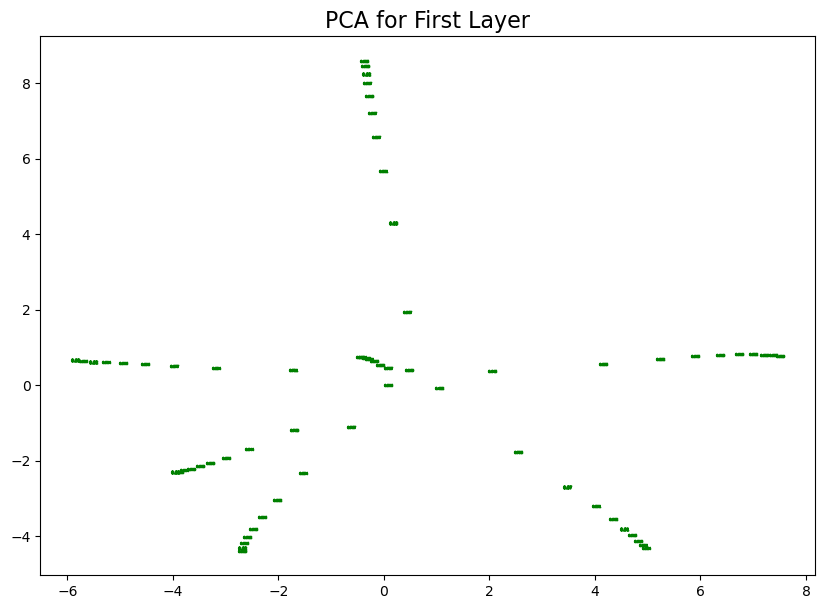

In [18]:
plt.figure(figsize=(10, 7))
for idx in range(66):
    accuracy_value = list(final_layer_data['Accuracy'])[idx]
    plt.scatter(final_layer_data['x'][idx*3], final_layer_data['y'][idx*3], marker=f'${accuracy_value}$', color='green')
    plt.title("PCA for First Layer", fontsize=16)
plt.show()